In [1]:
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Download and Visualise Data Tutorial

- Author: Quentin Petit
- Date: 2023-05-13

This notebook will guide you through the process of downloading and viewing universe simulations using the EAGLE dataset.

In [2]:
import sys
sys.path.append(r"../MOGPy/")

import utils.functions as f0
import utils.eagle_functions as eagle_f0

import os
import h5py
import eagleSqlTools as sql
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import rcParams
import matplotlib.gridspec as gridspec

font = {'family' : 'serif', 'size' : '20'}
plt.rc('font', **font)
px = 1/plt.rcParams['figure.dpi']

In [3]:
# List all snapshots and redshifts of the EAGLE simulation
A = [f'0{n}' for n in range(10)]
Abis = [f'{n+10}' for n in range(28-9)]
A.extend(Abis)
z = ['020','015','009','008','008','007','005','005','005','004','003','003','003','002','002','002','001','001','001','001','000','000','000','000','000','000','000','000','000']
p = ['000','132','993','988','075','050','971','487','037','485','984','528','017','478','237','012','737','487','259','004','865','736','615','503','366','271','183','101','000']
B = [f'snapshot_0{A}_z{z}p{p}' for A,z,p in zip(A,z,p)]
C = [f'snap_0{A}_z{z}p{p}' for A,z,p in zip(A,z,p)]

# Choose catalogue
Catalogue_Ref = 'RefL0025N0376'

# Choose Snapshot N
N = 23
Snapshot_number = A[N]
Snapshot_name   = B[N]
Snapshot_file   = C[N]

## Download catalogues

### /!\ Caution - This code works for small catalogues. For larger catalogues you need a lot of RAM. It is better to run this kind of code on dedicated compute servers. 

The provided code snippet checks if a specific file exists in the MOGPy/catalogues_hdf5/{Catalogue_Ref}/{Snapshot_name} directory. If the file exists, the code block does nothing (pass). If the file does not exist, it performs the following actions:

1. Uses the os.system function to download a file using the wget command. The file is downloaded from a specific URL, which includes authentication parameters (--user and --password).
2. Uses the os.system function to extract the contents of a tar file (tar -xvf) with the filename {Catalogue_Ref}_snap_0{N}.tar. The extraction process will create multiple files.
3. Removes the tar file ({Catalogue_Ref}_snap_0{N}.tar) using os.remove.

This code is used to ensure that a specific file exists in the designated directory. If the file is not found, it is downloaded, extracted, and then the tar file is removed.

In [4]:
if os.path.exists(f'../data/catalogues_hdf5/{Catalogue_Ref}/{Snapshot_name}/{Snapshot_file}.0.hdf5'):
    pass
else:
    os.system(f'wget --user= --password= --content-disposition --no-check-certificate "https://dataweb.cosma.dur.ac.uk:8443/eagle-snapshots//download?run={Catalogue_Ref}&snapnum={N}"')
    os.system(f'tar -xvf {Catalogue_Ref}_snap_0{N}.tar')
    os.remove(f'{Catalogue_Ref}_snap_0{N}.tar')

## Open HDF5

Read EAGLE data from download HDF5 files, process it, and save as *FITS* files.

Personally, I prefer to work with a single *.fits* file that contains all the particles of the snapshot in question. This choice becomes an inconvenience when one wishes to study much larger catalogues. 

Here you can limit your querry to a mass range between *MinMass* and *MaxMass* by choosing $X$ as $M = 10^X$ M$_\odot$.

In [5]:
MinMass = 5
MaxMass = 13

_ = eagle_f0.read_eagle(Catalogue_Ref, Snapshot_file, Snapshot_name, Snapshot_number, MinMass, MaxMass)

Check if Stage 1 is already done...
Stage 1 done!
Saving
Done!


## Visualise Data

In [6]:
# OPEN data
hdu = Table.read(f'../data/catalogues_fits/{Catalogue_Ref}/{Snapshot_name}/EAGLE_{Catalogue_Ref}_Snapshot{Snapshot_number}_MassMIN{MinMass}_MassMAX{MaxMass}.fits',format='fits')
data = hdu.to_pandas()
data.keys()

Index(['GroupNumber', 'SubGroupNumber', 'itype', 'Mass', 'Coordinates_x',
       'Coordinates_y', 'Coordinates_z', 'Velocity_x', 'Velocity_y',
       'Velocity_z'],
      dtype='object')

In [7]:
data.head()

,GroupNumber,SubGroupNumber,itype,Mass,Coordinates_x,Coordinates_y,Coordinates_z,Velocity_x,Velocity_y,Velocity_z
0,6038,1073741824,0.0,1.808490e+06,2.013921,4.112672,1.957235,70.360550,20.454130,51.612411
1,6038,0,0.0,1.808490e+06,2.042732,4.123199,1.954742,68.939247,43.752346,44.101055
2,6038,0,0.0,1.808490e+06,2.040406,4.124025,1.952351,100.645226,42.520416,57.990383
3,6038,1073741824,0.0,1.808490e+06,2.049251,4.144318,1.968098,65.499779,15.268905,26.360935
4,6038,1073741824,0.0,1.808490e+06,2.060639,4.142232,1.966242,77.388695,26.477516,39.959778


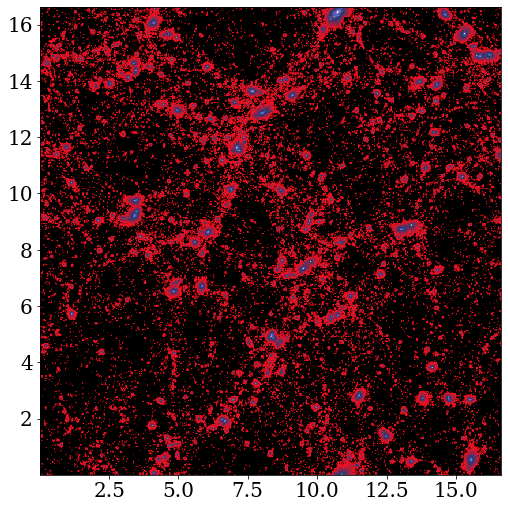

In [8]:
fig = plt.figure(figsize=(500*px,500*px),constrained_layout=True)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
ax = fig.add_subplot(spec[0, 0])

ax.hist2d(data['Coordinates_x'],data['Coordinates_y'],bins=(800,800),density=True,norm=mcolors.PowerNorm(0.4),cmap=plt.cm.gist_stern)

plt.show()